# DDA 4230 Tutorial 4

## Section 0:  Outline
1. Implement the multi-arm bandits (MAB) environment 
2. Implement & test the $\epsilon$-greedy algorithm
3. Implement & test the Explore-then-commit (ETC) algorithm
4. Implement & test Upper Confidence Bound (UCB) algorithm
5. Discussion

In [1]:
# Import libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

## Section 1: MAB Environment
Input
1. m_arm: Number of arms
2. Mean_reward: Expectation of reward for each arm
3. Std: Standard Deviation of reward for each amr

Methods
1. act(action): Select arm 'action' and return the observed reward


In [2]:
class Bandit:
    def __init__(self, m_arm=10, mean_reward=[1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9], 
                 std=np.ones(10)*1):
        self.true_mean = mean_reward
        self.m = m_arm
        self.std = std
        assert self.m == len(self.true_mean) and self.m == len(
            self.std), 'Number of arms must equal to numer of mean rewards/stds'

    def act(self, action):
        return np.random.randn()*self.std[action]+self.true_mean[action]


$std*N(0,1)+mean$

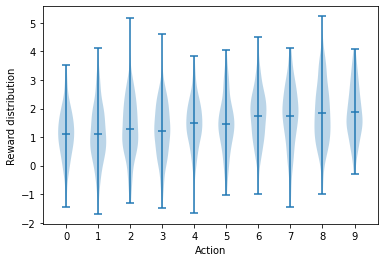

In [3]:
np.random.seed(1)
m=10
bandit_10=Bandit(m_arm=m)
data_set=np.zeros([200,m])
for i in range(m):
    for j in range(200):
        data_set[j,i]=bandit_10.act(i)
plt.violinplot(data_set,showmeans=True)
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.xticks(list(range(1,11)), list(range(10)))
plt.show()

## Section 2: $\epsilon$-greedy Algorithm

<img src="https://i.loli.net/2021/03/02/siHkyCf4LW7qMal.png" style="width: 800px;" center/>

Input
1. bandits: MAB environment
2. eps: value of $\epsilon$
3. T: Horizon

Return
1. q_hat: Reward estimation for each arm
2. avg_return_list: average return over time

A Trick: Incremental Implementation

Let $Q_n=\frac{R_1+R_2+...+R_{n-1}}{n-1}$, then, 
$$Q_{n+1}=\frac{1}{n}\sum_{i=1}^nR_i=\frac{1}{n}(R_n+\sum_{i=1}^{n-1}R_i)=\frac{1}{n}(R_n+(n-1)Q_n)=\frac{1}{n}(R_n-Q_n+nQ_n)=Q_n+\frac{1}{n}[R_n-Q_n]$$




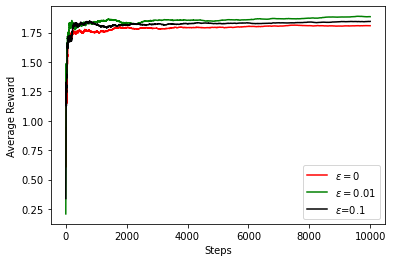

In [4]:
# Eps-greedy
def eps_greedy(bandits, eps, T=1000):
    m = bandits.m
    N = np.zeros(m)
    q_hat = np.zeros(m)
    avg_return = 0
    avg_return_list = np.zeros(T)
    for t in range(m):
        action = t
        reward = bandits.act(action)
        q_hat[action] = reward
        N[action] += 1
        avg_return += (reward-avg_return)/(t+2)
        avg_return_list[t] = avg_return
    for t in range(m, T):
        if np.random.rand() < eps:
            action = np.random.choice(m)
        else:
            action = np.argmax(q_hat)
        reward = bandits.act(action)
        q_hat[action] = (q_hat[action]*N[action]+reward)/(N[action]+1)
        N[action] += 1
        avg_return += (reward-avg_return)/(t+2)
        avg_return_list[t] = avg_return
    return q_hat, avg_return_list


T = 10000
q_hat, avg_return_list = eps_greedy(bandit_10, eps=0, T=T)
plt.plot(np.arange(T), avg_return_list, c='red')

q_hat, avg_return_list = eps_greedy(bandit_10, eps=0.01, T=T)
plt.plot(np.arange(T), avg_return_list, c='green')

q_hat, avg_return_list = eps_greedy(bandit_10, eps=0.1, T=T)
plt.plot(np.arange(T), avg_return_list, c='black')
plt.legend(["$\epsilon=0$", "$\epsilon=0.01$", "$\epsilon$=0.1"])

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()


## Section 3: ETC Algorithm

<img src="https://i.loli.net/2021/03/02/QUj5HoAK8d7Bien.png" style="width: 800px;" center/>

Input
1. bandits: MAB environment
2. k: number of exploration on each arm
3. T: Horizon

Return
1. q_hat: Reward estimation for each arm
2. avg_return_list: average return over time


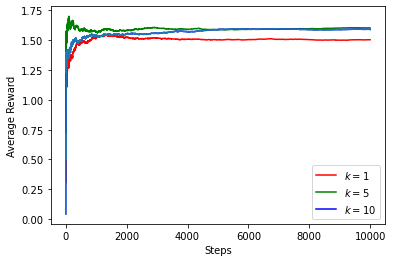

In [5]:
# ETC

def ETC(bandits, k=10, T=1000):
    m = bandits.m
    N = np.zeros(m)
    q_hat = np.zeros(m)
    avg_return = 0
    avg_return_list = np.zeros(T)
    for t in range(k*m):
        action = t % m
        reward = bandits.act(action)
        q_hat[action] = reward
        N[action] += 1
        avg_return += (reward-avg_return)/(t+2)
        avg_return_list[t] = avg_return
    old_q_hat=q_hat.copy()
    for t in range(k*m, T):
        action = np.argmax(old_q_hat)
        reward = bandits.act(action)
        q_hat[action] = (q_hat[action]*N[action]+reward)/(N[action]+1)
        N[action] += 1
        avg_return += (reward-avg_return)/(t+2)
        avg_return_list[t] = avg_return
    return q_hat, avg_return_list


T = 10000
q_hat, avg_return_list = ETC(bandit_10, k=1, T=T)
plt.plot(np.arange(T), avg_return_list, c='red')

q_hat, avg_return_list = ETC(bandit_10, k=5, T=T)
plt.plot(np.arange(T), avg_return_list, c='green')

q_hat, avg_return_list = ETC(bandit_10, k=10, T=T)
plt.plot(np.arange(T), avg_return_list, c='blue')

plt.legend(["$k=1$", "$k=5$", "$k=10$"])

plt.plot(np.arange(T), avg_return_list)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

## Section 4: UCB Algorithm

<img src="https://i.loli.net/2021/03/02/ke8jOh5DZxJCqYL.png" style="width: 800px;" center/>

Input
1. bandits: MAB environment
2. T: Horizon

Return
1. q_hat: Reward estimation for each arm
2. avg_return_list: average return over time


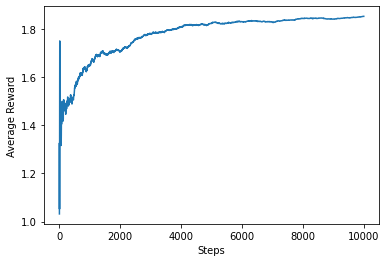

In [6]:
# UCB
def UCB(bandits, sigma, T=1000):
    m = bandits.m
    #sigma = bandits.std
    sigma=np.ones(m)*sigma
    N = np.zeros(m)
    q_hat = np.zeros(m)
    UCB = np.zeros(m)+np.inf
    avg_return = 0
    avg_return_list = np.zeros(T)

    for t in range(0, T):
        action = np.argmax(UCB)
        reward = bandits.act(action)
        q_hat[action] = (q_hat[action]*N[action]+reward)/(N[action]+1)
        UCB[action] = q_hat[action] + \
            np.sqrt(2*np.log(1/sigma[action])/(N[action]+1))
        N[action] += 1
        avg_return += (reward-avg_return)/(t+2)
        avg_return_list[t] = avg_return
    return q_hat, avg_return_list

T=10000
q_hat, avg_return_list = UCB(bandit_10,sigma=1/T**2, T=T)
plt.plot(np.arange(T), avg_return_list)
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

## Section 5: Discussion

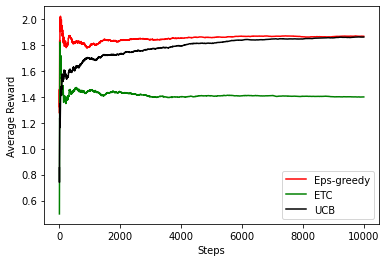

In [7]:
T=10000
q_hat_eps, avg_return_list_eps = eps_greedy(bandit_10, eps=0.1, T=T)
q_hat_etc, avg_return_list_etc = ETC(bandit_10, k=5, T=T)
q_hat_ucb, avg_return_list_ucb = UCB(bandit_10,sigma=1/T**2, T=T)
plt.plot(np.arange(T), avg_return_list_eps, c='red')
plt.plot(np.arange(T), avg_return_list_etc, c='green')
plt.plot(np.arange(T), avg_return_list_ucb, c='black')

plt.legend(["Eps-greedy", "ETC", "UCB"])

plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()